In [1]:
## Import packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import multinetx as mx
import scipy.io as sio
from networkx.readwrite import json_graph
import json
import pandas as pd
import os
import sys
from flask import Flask, render_template

print("Done importing packages :)")

Done importing packages :)


In [2]:
## Define useful functions

def write_mx_to_json(filename, mx, nNodes, pos, nLayers, nodes_to_remove = []):
    
    # filename the complete name of the output file (data/slide_x.json)
    # mx the multilayer network as a multinetx object
    # nNodes the number of nodes in the first layer
    # pos a dictionary of node coordinates
    # nLayers the number of layers in the second aspect.
    # nodes_to_remove is a list of nodes that should not exist in each layer. Default = []
    
    # From the sparse adj, make a networkx graph and add node attributes
    G1 = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())

    # Remove nodes from G
    G1.remove_nodes_from(nodes_to_remove)

    # Recreate the graph G to make the rest work nicely.
    G = nx.from_numpy_array(nx.adjacency_matrix(G1).todense())


    # Create dictionaries pretending like all nodes exist
    scalefact = 20
    L2_classes = np.arange(nLayers)
    L2_array_original = np.array([])
    z_shift = 2
    z_array_original = np.array([])
    x_orig = np.array([])
    y_orig = np.array([])
    L1_orig = np.array([])
    for level in L2_classes:
        L2_array_original = np.concatenate((L2_array_original, np.array([float(level) for i in np.arange(nNodes)])))
        z_array_original = np.concatenate((z_array_original, np.array([float(level*z_shift) for i in np.arange(nNodes)])))
        x_orig = np.concatenate((x_orig, [pos[key][0]+scalefact for key in pos]))
        y_orig = np.concatenate((y_orig, [pos[key][1]+scalefact for key in pos]))
        L1_orig = np.concatenate((L1_orig, [i for i in np.arange(nNodes)]))

    # Need to delete nodes from our attribute dictionaries, too
    L2_array = np.delete(L2_array_original, nodes_to_remove, 0)
    z_array = np.delete(z_array_original, nodes_to_remove, 0)
    x_array = np.delete(x_orig, nodes_to_remove, 0)
    y_array = np.delete(y_orig, nodes_to_remove, 0)
    L1_array = np.delete(L1_orig, nodes_to_remove, 0)

    ## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

    id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLayers)}
    x_dict = {}
    y_dict = {}
    L2_dict = {i:l2 for i,l2 in enumerate(L2_array)}
    z_dict = {i:z_val for i,z_val in enumerate(z_array)}
    x_dict = {i:x_val for i,x_val in enumerate(x_array)}
    y_dict = {i:y_val for i,y_val in enumerate(y_array)}
    L1_dict = {i:L1_val for i,L1_val in enumerate(L1_array)}


    # nx.set_node_attributes(G, pos, name="pos")
    nx.set_node_attributes(G, id_dict, name = "name")
    nx.set_node_attributes(G, x_dict, name = "x")
    nx.set_node_attributes(G, y_dict, name = "y")
    nx.set_node_attributes(G, z_dict, name = "z")
    nx.set_node_attributes(G, L1_dict, name= "L1")
    nx.set_node_attributes(G, L2_dict, name= "L2")

    G_json = json_graph.node_link_data(G)
    with open(filename, 'w') as fp:
        json.dump(G_json, fp)

    print(f"done writing mx to {filename}")




#Finished defining functions
print("finished defining functions")

finished defining functions


## Multilayer network ex 1: Two aspects, two layers

Aspect L1: nodes as usual
Aspect L2: "A" or "B"

In [18]:
# Set filename
filename = "data/mx_2layers.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 2

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=218)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=132)

# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*3,nNodes*3)))
adj_block[0:  nNodes,  nNodes:2*nNodes] = np.identity(nNodes)    # L_12
adj_block += adj_block.T

# Create multilayer graph with mx
mg = mx.MultilayerGraph(list_of_layers=[g1,g2],
                        inter_adjacency_matrix=adj_block)

# Here we can set the edge weights to different values just so we can see which are inter- and intra-layer edges
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)


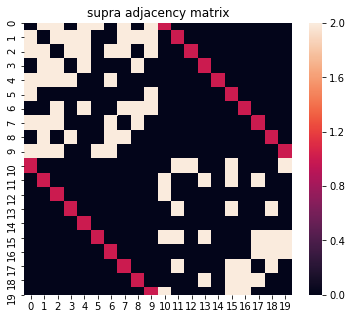

In [19]:
## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');


In [23]:
# Write to json file

# We'll use networkx positioning to get nice layouts. We create a layout using a layer that contains all nNodes nodes.
# In this case both layers are the same size so it doesn't matter :)

# Feel free to change the layout used here. It will be reflected in the d3 plot. However pos is changed, it should
# remain a dictionary mapping nodes to coordinate arrays with at least an x and y position.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3, k=1)

write_mx_to_json(filename,mx, nNodes, pos, nLayers)


done writing mx to data/mx_2layers.json


## Ex 2: 2 aspects, 5 layers


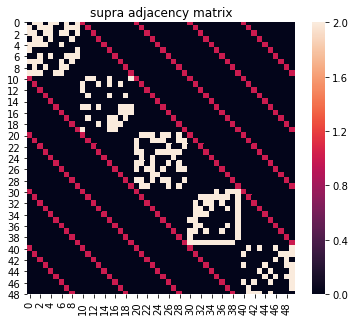

In [6]:
# Set filename
filename = "data/mx_5layers.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 5

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=218)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=132)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=192)
g4 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=19)
g5 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=102)

# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3,g4,g5],
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');



In [7]:
# Write to json file

# We'll use networkx positioning to get nice layouts. We create a layout using a layer that contains all nNodes nodes.
# In this case both layers are the same size so it doesn't matter :)
# Feel free to change the layout used here. It will be reflected in the d3 plot.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)

# write to json file
write_mx_to_json(filename, mx, nNodes, pos, nLayers)

done writing mx to data/mx_5layers.json


## Time series example

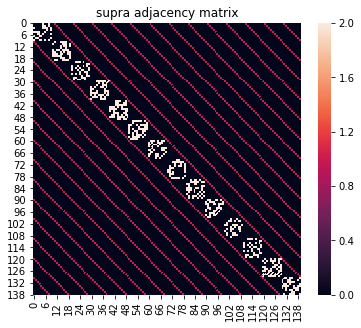

In [8]:
# Set filename
filename = "data/mx_timeseries.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 14

# Use multinetx to generate fourteen graphs each on nNodes nodes
graph_layers = [mx.generators.erdos_renyi_graph(nNodes,0.5,seed=np.random.randint(1,300)) for i in np.arange(nLayers)]


# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=graph_layers,
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');

In [9]:
# Write to json file

# We'll use networkx positioning to get nice layouts. We create a layout using a layer that contains all nNodes nodes.
# In this case both layers are the same size so it doesn't matter :)
# Feel free to change the layout used here. It will be reflected in the d3 plot.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)

# write to json file
write_mx_to_json(filename, mx, nNodes, pos, nLayers)

done writing mx to data/mx_timeseries.json


## Non-identity inter-layer connections

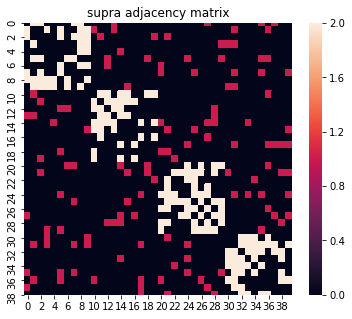

In [10]:
# Set filename
filename = "data/mx_nonidentity.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 4

# Use multinetx to generate graphs each on nNodes nodes
graph_layers = [mx.generators.erdos_renyi_graph(nNodes,0.5,seed=np.random.randint(1,300)) for i in np.arange(nLayers)]


# Define adjacency between layers. Now we randomly connect nodes in separate layers.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.random.choice([0,1],size=(nNodes,nNodes),replace=True,p=[0.9,0.1])   # L_1*

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=graph_layers,
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix');



In [11]:
# Write to json file

# We'll use networkx positioning to get nice layouts. We create a layout using a layer that contains all nNodes nodes.
# In this case both layers are the same size so it doesn't matter :)
# Feel free to change the layout used here. It will be reflected in the d3 plot.
pos = nx.layout.fruchterman_reingold_layout(g1, dim=3)

# write to json file
write_mx_to_json(filename, mx, nNodes, pos, nLayers)

done writing mx to data/mx_nonidentity.json


## Case where nodes are not in every layer

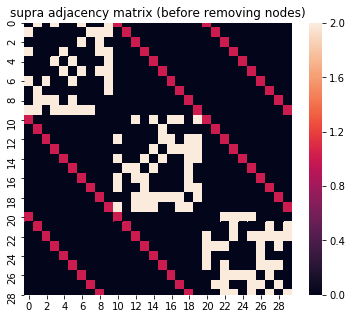

In [12]:
# When we do not have all nNodes in each layer, we will proceed as before but then delete nodes towards the end

# Set filename
filename = "data/mx_missingnodes.json"

# Define number of nodes (number of nodes in largest layer)
nNodes = 10

# Define number of levels
nLayers = 3

# Set which nodes should not exist in the final graph
nodes_to_remove = [11, 17, 21, 25, 28]

# Use multinetx to generate two graphs each on nNodes nodes
g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=102)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=54)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=194)


# Define adjacency between layers. Here we only assign nodes to themselves in each layer.
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3],
                        inter_adjacency_matrix=adj_block)

# Set edge weights
mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)

## Plot the supra-adjacency matrix
fig = plt.figure(figsize=(6,5))
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
plt.title('supra adjacency matrix (before removing nodes)');



In [13]:
# Since nodes don't exist in every layer, it might be easier to visualize with a circular layout...
pos = nx.circular_layout(g1)

# Write to json -- make sure to add nodes_to_remove
write_mx_to_json(filename, mx, nNodes, pos, nLayers, nodes_to_remove)

done writing mx to data/mx_missingnodes.json
